
# Lab: TimeSeriesSplit (Multivariate → Time-Series Output)
**ไฟล์นี้สร้างโดยอัตโนมัติ** — สอนการใช้ `TimeSeriesSplit` สำหรับปัญหาพยากรณ์เวลา (forecasting) แบบ 1-step ahead โดยใช้ฟีเจอร์หลายตัว (multivariate / exogenous) + lag/rolling features


## 0) Setup

In [1]:

# --- core ---
import numpy as np
import pandas as pd

# --- modeling ---
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# --- metrics & viz ---
import matplotlib.pyplot as plt

# reproducibility
RNG = np.random.RandomState(42)

def mae_score(y_true, y_pred):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))

def rmse_score(y_true, y_pred):
    """Root Mean Squared Error"""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))



## 1) Build a toy but realistic multivariate time-series dataset
เราจำลอง target `y` (รายวัน ~2 ปี) มีแนวโน้ม + seasonality รายสัปดาห์ + noise และตัวแปรอธิบายภายนอก (exogenous): `promo`, `temperature`, `macro_index`


In [2]:

# --- generate a 2-year daily series ---
N_DAYS = 730  # ~2 years
dates = pd.date_range('2022-01-01', periods=N_DAYS, freq='D')

# latent components
trend = 0.03 * np.arange(N_DAYS)
season_weekly = 5 * np.sin(2*np.pi*np.arange(N_DAYS)/7)  # weekly
noise = RNG.normal(0, 2.0, size=N_DAYS)

# exogenous drivers
promo = (RNG.rand(N_DAYS) < 0.12).astype(int)  # 12% promo days
temperature = 28 + 6*np.sin(2*np.pi*(np.arange(N_DAYS)-30)/365) + RNG.normal(0, 1.0, N_DAYS)
macro_index = np.cumsum(RNG.normal(0, 0.05, N_DAYS))  # slow drift

# target depends on exogenous vars + latent components
y = 20 + trend + season_weekly + 3*promo - 0.4*(temperature-28) + 0.8*macro_index + noise

df = pd.DataFrame({
    'date': dates,
    'promo': promo,
    'temperature': temperature,
    'macro_index': macro_index,
    'y': y,
}).set_index('date')

df.head()


,promo,temperature,macro_index,y
date,,,,
2022-01-01,1,25.119176,-0.150976,25.024977
2022-01-02,0,25.028707,-0.141783,24.737719
2022-01-03,1,26.137775,-0.051758,29.933501
2022-01-04,0,25.020349,0.010190,26.505490
2022-01-05,0,25.670739,0.020673,18.430517



## 2) Create lag/rolling features (feature engineering)
พยากรณ์ `y` ของวันถัดไปด้วยข้อมูลอดีต (lag) + rolling stats + ตัวแปรภายนอก


In [3]:

def make_lag_features(df, target_col='y', lags=(1,2,3,7), roll_windows=(3,7,14)):
    df = df.copy()
    for L in lags:
        df[f'{target_col}_lag{L}'] = df[target_col].shift(L)
    for W in roll_windows:
        df[f'{target_col}_rollmean{W}'] = df[target_col].shift(1).rolling(W).mean()
        df[f'{target_col}_rollstd{W}']  = df[target_col].shift(1).rolling(W).std()
    return df

feat_df = make_lag_features(df, 'y')
feat_df = feat_df.dropna().copy()

X = feat_df.drop(columns=['y'])
y = feat_df['y']

X.shape, y.shape


((716, 13), (716,))

In [17]:
X

,promo,temperature,macro_index,y_lag1,y_lag2,y_lag3,y_lag7,y_rollmean3,y_rollstd3,y_rollmean7,y_rollstd7,y_rollmean14,y_rollstd14
date,,,,,,,,,,,,,
2022-01-15,0,27.454147,0.220749,13.527909,16.887804,18.541840,22.263860,16.319184,2.554872,21.145502,5.482473,22.072607,5.111926
2022-01-16,0,26.942578,0.132295,17.365105,13.527909,16.887804,24.176802,15.926939,2.091282,20.445680,5.626685,21.525473,5.181078
2022-01-17,0,26.542936,0.097559,23.763387,17.365105,13.527909,30.410369,18.218800,5.170865,20.386621,5.582995,21.455878,5.140999
2022-01-18,0,27.486237,0.077095,23.989850,23.763387,17.365105,22.209932,21.706114,3.761129,19.469404,3.950478,21.031332,4.604479
2022-01-19,0,28.159581,0.050891,23.575094,23.989850,23.763387,18.541840,23.776110,0.207670,19.664427,4.137585,20.822018,4.398486
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0,23.360531,1.259179,46.386425,51.280126,45.485047,44.666115,47.717199,3.118326,44.120848,4.125057,44.557663,4.236147
2023-12-28,0,24.745321,1.346953,42.075745,46.386425,51.280126,39.663645,46.580765,4.605267,43.750795,4.183760,44.586769,4.216120
2023-12-29,0,25.049346,1.425604,39.321662,42.075745,46.386425,40.548015,42.594611,3.560847,43.701940,4.241046,44.671149,4.087023


In [18]:
y

date
2022-01-15    17.365105
2022-01-16    23.763387
2022-01-17    23.989850
2022-01-18    23.575094
2022-01-19    16.531413
                ...    
2023-12-27    42.075745
2023-12-28    39.321662
2023-12-29    40.916750
2023-12-30    42.594265
2023-12-31    47.082704
Name: y, Length: 716, dtype: float64


## 3) Visualize TimeSeriesSplit (Expanding vs Rolling)
- **Expanding**: train โตขึ้นเรื่อย ๆ (`max_train_size=None`)
- **Rolling**: ความยาว train คงที่ (`max_train_size=...`) เลื่อนไปเรื่อย ๆ


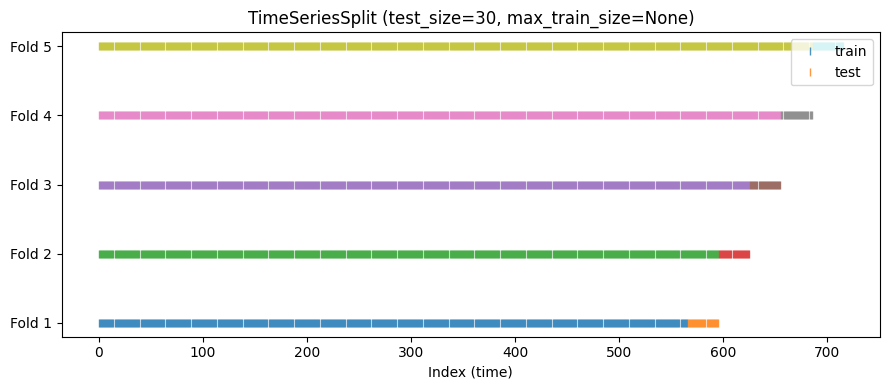

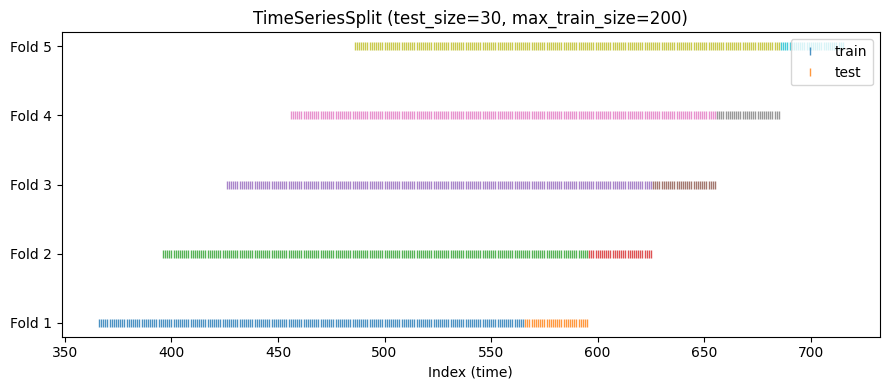

In [4]:

def show_tscv(n_splits=5, test_size=30, max_train_size=None):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, max_train_size=max_train_size)
    n = len(X)
    fig, ax = plt.subplots(figsize=(9, 2 + 0.4*n_splits))
    for i, (tr, te) in enumerate(tscv.split(np.arange(n)), 1):
        ax.plot(tr, [i]*len(tr), marker='|', linestyle='None', label='train' if i==1 else "", alpha=0.8)
        ax.plot(te, [i]*len(te), marker='|', linestyle='None', label='test' if i==1 else "", alpha=0.8)
    ax.set_yticks(range(1, n_splits+1))
    ax.set_yticklabels([f'Fold {i}' for i in range(1, n_splits+1)])
    ax.set_xlabel('Index (time)')
    ax.legend(loc='upper right')
    ax.set_title(f'TimeSeriesSplit (test_size={test_size}, max_train_size={max_train_size})')
    plt.tight_layout()
    plt.show()

# Expanding window
show_tscv(n_splits=5, test_size=30, max_train_size=None)

# Rolling window
show_tscv(n_splits=5, test_size=30, max_train_size=200)



## 4) Baseline model with expanding window CV
ใช้ `Ridge` (เชิงเส้น) + scaling เป็น baseline


In [5]:

tscv = TimeSeriesSplit(n_splits=5, test_size=30, max_train_size=None)  # expanding

pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('model', Ridge(alpha=1.0, random_state=42)),
])

results = []
all_preds = []

for fold_idx, (tr, te) in enumerate(tscv.split(X), 1):
    X_tr, y_tr = X.iloc[tr], y.iloc[tr]
    X_te, y_te = X.iloc[te], y.iloc[te]

    pipe.fit(X_tr, y_tr)
    y_hat = pipe.predict(X_te)

    mae = mae_score(y_te, y_hat)
    rmse = rmse_score(y_te, y_hat)

    fold_df = pd.DataFrame({
        'y_true': y_te.values,
        'y_pred': y_hat,
        'fold': fold_idx
    }, index=y_te.index)
    all_preds.append(fold_df)

    results.append({
        'fold': fold_idx,
        'train_end': X_tr.index[-1],
        'test_start': X_te.index[0],
        'test_end': X_te.index[-1],
        'MAE': mae,
        'RMSE': rmse
    })

results_df = pd.DataFrame(results)
results_df


,fold,train_end,test_start,test_end,MAE,RMSE
0,1,2023-08-03,2023-08-04,2023-09-02,2.150346,2.683645
1,2,2023-09-02,2023-09-03,2023-10-02,1.799857,2.485565
2,3,2023-10-02,2023-10-03,2023-11-01,2.250587,2.930637
3,4,2023-11-01,2023-11-02,2023-12-01,2.170466,2.676249
4,5,2023-12-01,2023-12-02,2023-12-31,2.026984,2.400980


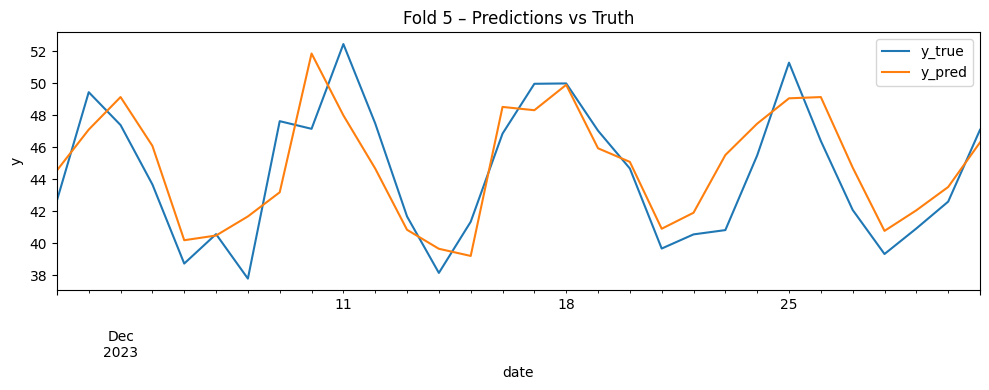

Mean MAE: 2.079647860153489
Mean RMSE: 2.6354148844455674


In [6]:

# Plot predictions vs truth for the last fold
preds_df = pd.concat(all_preds).sort_index()
last_fold = preds_df['fold'].max()
ax = preds_df.query('fold == @last_fold')[['y_true','y_pred']].plot(figsize=(10,4))
ax.set_title(f'Fold {last_fold} – Predictions vs Truth')
ax.set_ylabel('y')
plt.tight_layout(); plt.show()

print("Mean MAE:", results_df['MAE'].mean())
print("Mean RMSE:", results_df['RMSE'].mean())



## 5) Rolling window variant (fixed train length)
เหมาะกับกรณี concept drift เร็ว


In [7]:

tscv_roll = TimeSeriesSplit(n_splits=5, test_size=30, max_train_size=200)

results_roll = []
for fold_idx, (tr, te) in enumerate(tscv_roll.split(X), 1):
    X_tr, y_tr = X.iloc[tr], y.iloc[tr]
    X_te, y_te = X.iloc[te], y.iloc[te]

    pipe.fit(X_tr, y_tr)
    y_hat = pipe.predict(X_te)

    results_roll.append({
        'fold': fold_idx,
        'train_len': len(tr),
        'MAE': mae_score(y_te, y_hat),
        'RMSE': rmse_score(y_te, y_hat)
    })

pd.DataFrame(results_roll)


,fold,train_len,MAE,RMSE
0,1,200,2.135221,2.859589
1,2,200,2.301211,2.782196
2,3,200,2.178328,2.811950
3,4,200,2.393629,2.819519
4,5,200,2.113072,2.596347



## 6) Compare models: Ridge vs RandomForest (same splits)
เปรียบเทียบโมเดลเชิงเส้นกับแบบไม่เชิงเส้น


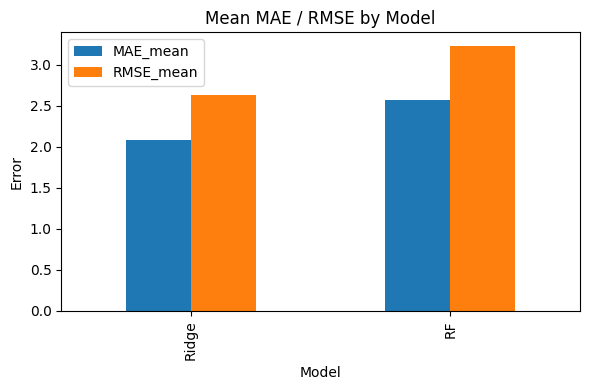

,MAE_mean,RMSE_mean
model,,
Ridge,2.079648,2.635415
RF,2.568263,3.231488


In [8]:

models = {
    'Ridge': Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0, random_state=42))]),
    'RF'   : RandomForestRegressor(
        n_estimators=400, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        random_state=42, n_jobs=-1
    )
}

tscv_cmp = TimeSeriesSplit(n_splits=5, test_size=30)

summary = []

for name, mdl in models.items():
    fold_scores = []
    for tr, te in tscv_cmp.split(X):
        X_tr, y_tr = X.iloc[tr], y.iloc[tr]
        X_te, y_te = X.iloc[te], y.iloc[te]
        mdl.fit(X_tr, y_tr)
        y_hat = mdl.predict(X_te)
        fold_scores.append((mae_score(y_te, y_hat), rmse_score(y_te, y_hat)))
    maes, rmses = zip(*fold_scores)
    summary.append({'model': name, 'MAE_mean': np.mean(maes), 'RMSE_mean': np.mean(rmses)})

summary_df = pd.DataFrame(summary).set_index('model')
ax = summary_df[['MAE_mean','RMSE_mean']].plot(kind='bar', figsize=(6,4))
ax.set_title('Mean MAE / RMSE by Model')
ax.set_ylabel('Error'); ax.set_xlabel('Model')
plt.tight_layout(); plt.show()

summary_df



## 7) (Optional) Proper GridSearchCV with nested TimeSeriesSplit (no leakage)
จูนพารามิเตอร์บน **inner** TSCV เฉพาะส่วน train ของ **outer** fold เท่านั้น


In [15]:

outer_tscv = TimeSeriesSplit(n_splits=5, test_size=30)        # outer expanding CV
inner_tscv = TimeSeriesSplit(n_splits=3, test_size=20)        # inner expanding CV for tuning

ridge_pipe = Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=42))])
ridge_grid = {'model__alpha': [0.008,0.0012,0.0015,0.0025,0.005,0.01,0.05, 0.1, 0.5]}

outer_results = []
for fold_idx, (tr, te) in enumerate(outer_tscv.split(X), 1):
    X_tr, y_tr = X.iloc[tr], y.iloc[tr]
    X_te, y_te = X.iloc[te], y.iloc[te]

    search = GridSearchCV(
        estimator=ridge_pipe,
        param_grid=ridge_grid,
        scoring='neg_root_mean_squared_error',
        cv=inner_tscv,
        n_jobs=-1,
        return_train_score=True
    )
    search.fit(X_tr, y_tr)  # tune ONLY on outer-train

    best_model = search.best_estimator_
    y_hat = best_model.predict(X_te)

    outer_results.append({
        'fold': fold_idx,
        'best_alpha': search.best_params_['model__alpha'],
        'MAE': mae_score(y_te, y_hat),
        'RMSE': rmse_score(y_te, y_hat)
    })

outer_results_df = pd.DataFrame(outer_results)
print("\nMean MAE:", outer_results_df['MAE'].mean())
print("Mean RMSE:", outer_results_df['RMSE'].mean())
outer_results_df



Mean MAE: 2.0721501198650354
Mean RMSE: 2.6291174514736584


,fold,best_alpha,MAE,RMSE
0,1,0.0012,2.128710,2.668838
1,2,0.0012,1.801949,2.484150
2,3,0.0012,2.213395,2.919086
3,4,0.0012,2.147856,2.645990
4,5,0.0012,2.068840,2.427523



## 8) Quick utility: Compare “no grid” vs “with grid”


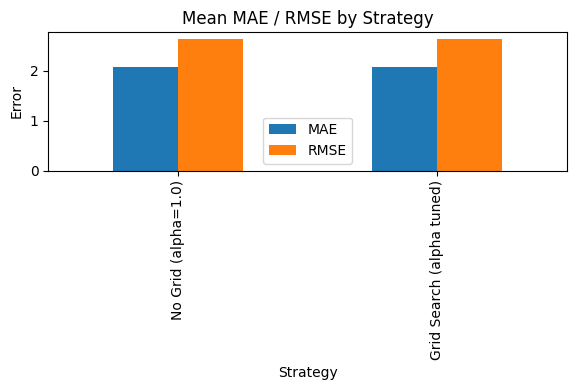

,MAE,RMSE
Strategy,,
No Grid (alpha=1.0),2.079648,2.635415
Grid Search (alpha tuned),2.072872,2.629589


In [16]:

def evaluate_no_grid(model, tscv):
    scores = []
    for tr, te in tscv.split(X):
        model.fit(X.iloc[tr], y.iloc[tr])
        y_hat = model.predict(X.iloc[te])
        scores.append((mae_score(y.iloc[te], y_hat), rmse_score(y.iloc[te], y_hat)))
    maes, rmses = zip(*scores)
    return np.mean(maes), np.mean(rmses)

def evaluate_with_grid(pipe, grid, tscv_outer, tscv_inner):
    maes, rmses = [], []
    for tr, te in tscv_outer.split(X):
        X_tr, y_tr = X.iloc[tr], y.iloc[tr]
        X_te, y_te = X.iloc[te], y.iloc[te]
        gs = GridSearchCV(pipe, grid, scoring='neg_root_mean_squared_error', cv=tscv_inner, n_jobs=-1)
        gs.fit(X_tr, y_tr)
        y_hat = gs.best_estimator_.predict(X_te)
        maes.append(mae_score(y_te, y_hat))
        rmses.append(rmse_score(y_te, y_hat))
    return np.mean(maes), np.mean(rmses)

tscv_outer = TimeSeriesSplit(n_splits=5, test_size=30)
tscv_inner = TimeSeriesSplit(n_splits=3, test_size=20)

no_grid_mae, no_grid_rmse = evaluate_no_grid(
    Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0, random_state=42))]),
    tscv_outer
)
grid_mae, grid_rmse = evaluate_with_grid(
    Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=42))]),
    {'model__alpha':[0.1,0.3,1.0,3.0,10.0]},
    tscv_outer, tscv_inner
)

summary_cmp = pd.DataFrame({
    'Strategy': ['No Grid (alpha=1.0)','Grid Search (alpha tuned)'],
    'MAE': [no_grid_mae, grid_mae],
    'RMSE': [no_grid_rmse, grid_rmse],
}).set_index('Strategy')
ax = summary_cmp.plot(kind='bar', figsize=(6,4))
ax.set_title('Mean MAE / RMSE by Strategy')
ax.set_ylabel('Error'); ax.set_xlabel('Strategy')
plt.tight_layout(); plt.show()

summary_cmp



## 9) Tips & Notes
- ใช้ `gap=` ใน `TimeSeriesSplit` เพื่อกันข้อมูลติดกันระหว่าง train/test หากเสี่ยง leakage
- ทดลองเพิ่มฟีเจอร์: วันหยุด/เสาร์อาทิตย์, one-hot เดือน/วันในสัปดาห์, rolling quantiles, expanding mean
- ลองโมเดลอื่น ๆ เช่น `Lasso`, `ElasticNet`, `GradientBoostingRegressor`, `HistGradientBoostingRegressor`
